# Quick Overview

In this task, you will implement a simple variant of [EfficientDet](https://arxiv.org/abs/1911.09070) for the segmentation task on [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). 
It is a simplified task where the pet can be classified as foreground.

The dataset consists of RGB images of pets accompanied by a segmentation mask. The mask is an array of integers, that has entries equal to:
* 1 - for the pixels of the image that belong to the pet
* 2 - for the background
* 3 - for the ambiguous parts (like pet boundary and accessories) - we will call this an outline of a pet

The task is divided into four parts that contribute to your total score as follows:
* dataset preparation - 0.5p
* data visualization - 0.5p
* architecture implementation - 5p
* evaluation metrics - 1p
* training loop - 1p
* experiments - 2p

The first two subtasks consider dataset preparation (applying appropriate transforms) and data visualization.

In the next one, you are tasked with finishing the implementation of a model that should utilize:
* [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) backbone
* [BiFPN](https://arxiv.org/abs/1911.09070)-like module 
* Fully convolutional head for predicting whether a pixel belongs to the pet, the background, or the pet outline

Given a batch of input images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` the model should produce a tensor of shape `(BATCH, 3, PREDICTION_HEIGHT, PREDICTION_WIDTH)` consisting of logits used later for determining whether the point belongs to the pet, the background, or the pet outline.

Next, you will implement IOU and accuracy metrics, and finish the training loop (the evaluation function is already provided).

In the end, you will check how much the model benefits from the use of the feature pyramid and check the effects of the train set augmentation in a low data regime.

# Intro

## Libraries

In [47]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import itertools 

## Dataset Preparation (0.5p)

Read this section and provide input and target transforms. 
Transforms should pass the checks presented at the end of the section.

Input (Image) transforms should consist of:
* resize to ``(IMAGE_HEIGHT, IMAGE_WIDTH)``
* normalization with parameters matching ImageNet (provided below)

Target (Mask) transforms should consist of:
* resize to ``(PREDICTION_HEIGHT, PREDICTION_WIDTH)`` that maintains the domain (i.e. if each element of the mask was from the set {1, 2, 3} then so does each element after the resize)
* subtraction of 1 from each element of the target (to make 0 correspond to the pet, 1 to the background, and 2 to the outline)
* conversion to `torch.long`

Both inputs and targets should be converted to tensors.

Each image should have shape `(3, IMAGE_HEIGHT, IMAGE_WIDTH)`, 
whereas each target `(PREDICTION_HEIGHT, PREDICTION_WIDTH)`.

HINT:
* `torchvision.transforms.ToTensor()`
* `torchvision.transforms.PILToTensor()`
* `torchvision.transforms.Normalize(...)`
* `torchvision.transforms.Resize(..., interpolation=...)`
* `torchvision.transforms.Lambda(...)`

In [48]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

input_transforms = torchvision.transforms.Compose(
    [

        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.Normalize(
            mean = image_net_mean,
            std = image_net_std
        )
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.PILToTensor(),
        torchvision.transforms.Resize((PREDICTION_HEIGHT, PREDICTION_WIDTH), interpolation=torchvision.transforms.InterpolationMode.NEAREST),
        torchvision.transforms.Lambda(lambda x: x - 1),
        torchvision.transforms.Lambda(lambda x: torch.squeeze(x).long())
    ]
)

In [49]:
# Directory for dataset storage
DATA_PATH = "~/torch_datasets/oxford"

TRAIN_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="trainval",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)
TEST_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="test",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)

In [50]:
BATCH_SIZE = 16
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Let's ensure that shapes and types match our expectations.

In [51]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long
assert (masks <= 2).all()
assert (masks >= 0).all()

## Data Visualization (0.5p)
Finish the implementation of `visualize_data` according to its docstring.

In [52]:
def get_pet_mask(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet.
    """
    return (mask == 0).type(torch.long)


def get_pet_background(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the background.
    """
    return (mask == 1).type(torch.long)


def get_pet_outline(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet outline.
    """
    return (mask == 2).type(torch.long)

In [53]:
def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    Draws a grid of images of size BATCH x 4.
    I'th row consists of the image, pet mask, pet outline, and background mask.
    """
    assert len(images.shape) == 4
    assert len(masks.shape) == 3
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    fig, axes = plt.subplots(num_images, 4, figsize=(20, 20))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].imshow(get_pet_mask(masks[i]))
        axes[i, 2].imshow(get_pet_outline(masks[i]))
        axes[i, 3].imshow(get_pet_background(masks[i]))
        
    plt.show(fig)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


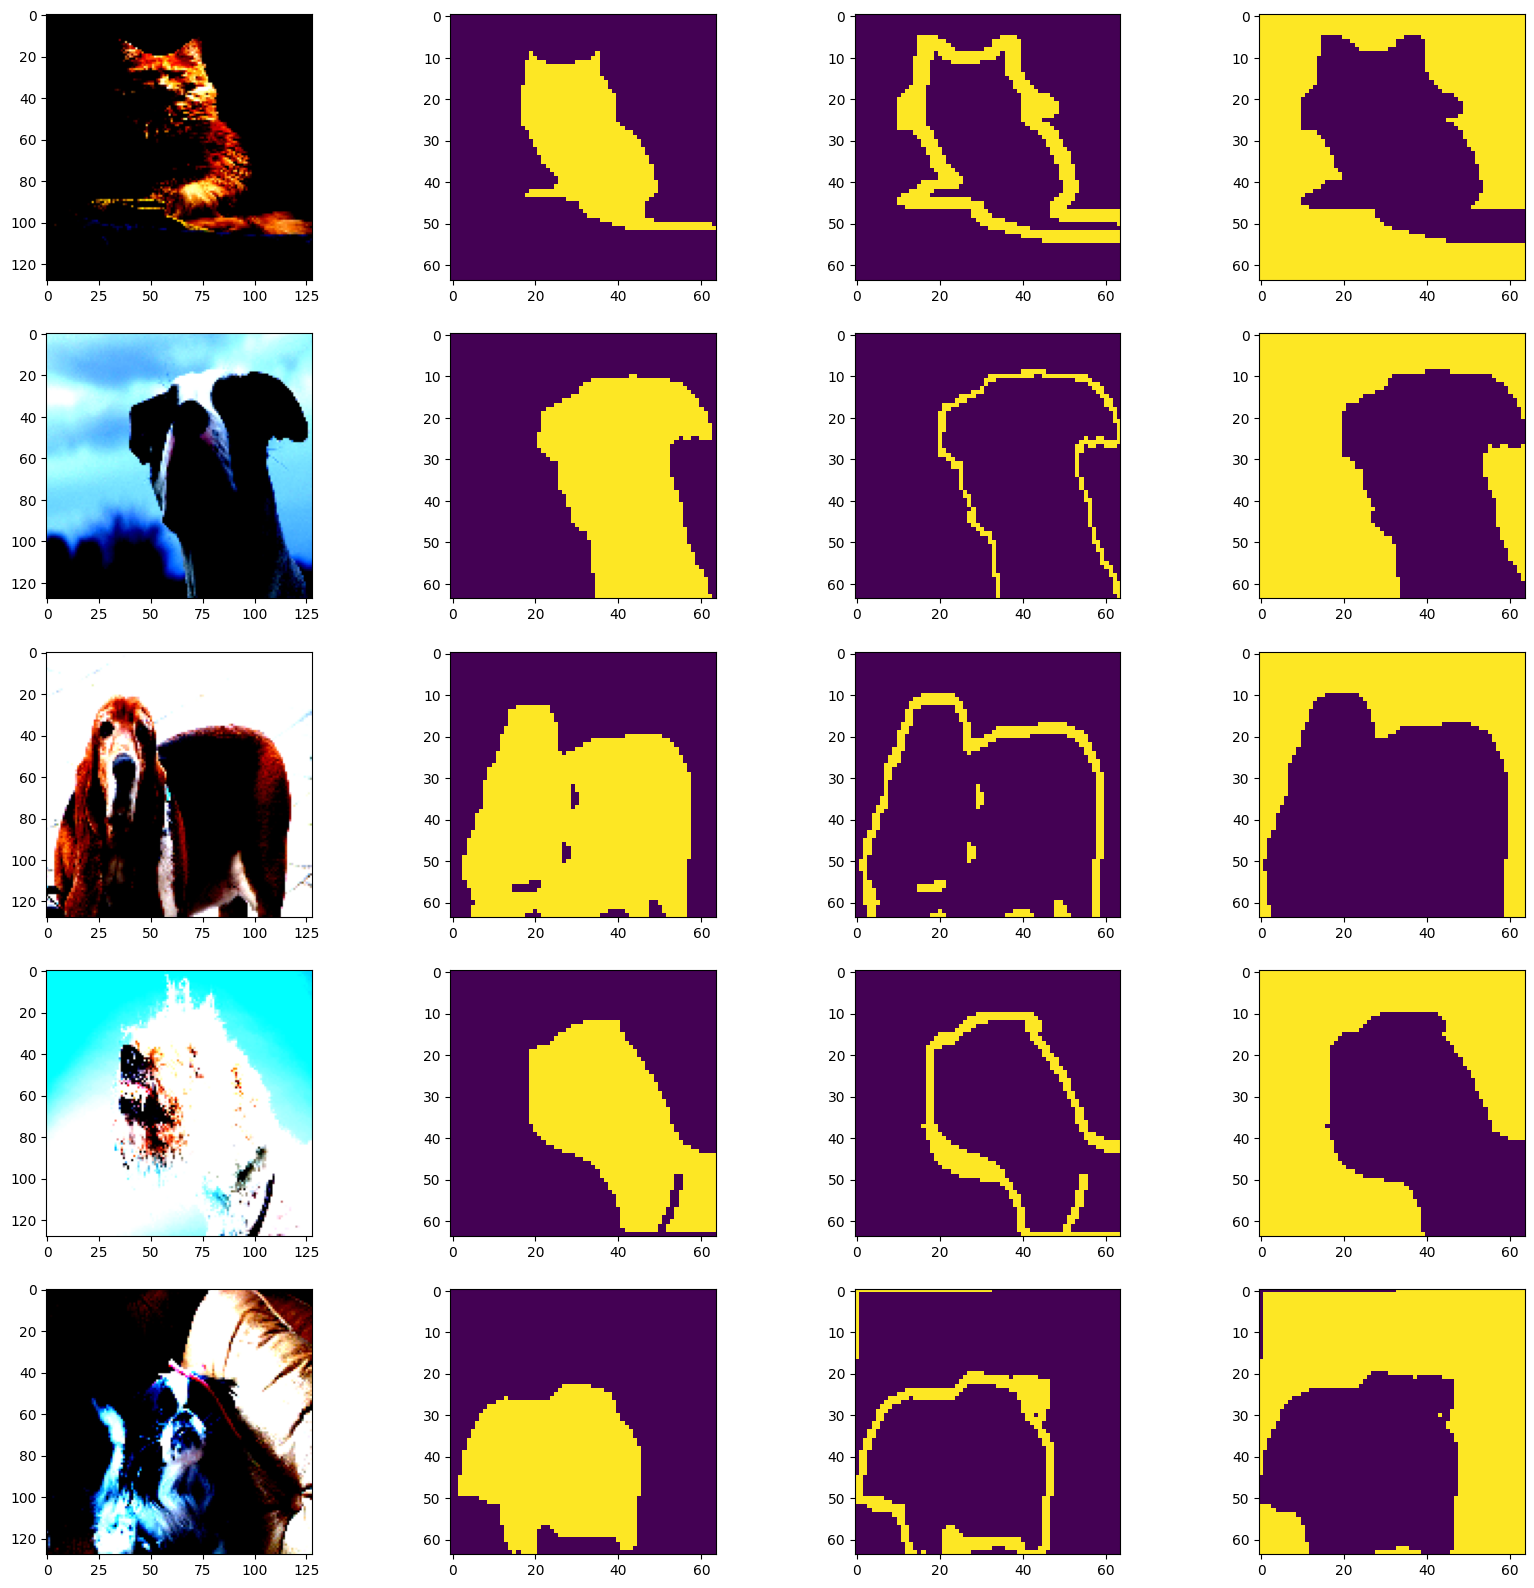

In [54]:
visualize_data(images[:5], masks[:5])

# Model

## Backbone Selection

We are going to use [EfficientNet](https://arxiv.org/abs/1905.11946v5) as the backbone of our model. Below we install a PyTorch implementation and a package for model summarization.

In [55]:
!pip install efficientnet_pytorch
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [56]:
from efficientnet_pytorch import EfficientNet
backbone = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [57]:
import torchinfo
torchinfo.summary(backbone, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH), device="cpu")

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [1, 1000]                 --
├─Conv2dStaticSamePadding: 1-1                     [1, 32, 64, 64]           864
│    └─ZeroPad2d: 2-1                              [1, 3, 129, 129]          --
├─BatchNorm2d: 1-2                                 [1, 32, 64, 64]           64
├─MemoryEfficientSwish: 1-3                        [1, 32, 64, 64]           --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 16, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 32, 64, 64]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 64, 64]           64
│    │    └─MemoryEfficientSwish: 3-3              [1, 32, 64, 64]           --
│    │    └─Conv2dStaticSamePadding: 3-4           [1, 8, 1, 1]              264
│    │    └─MemoryEfficientSwish

The backbone has a method that allows easy feature extraction.
Below we inspect this method.

In [58]:
import json

dummy_input = torch.zeros((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
features = backbone.extract_endpoints(dummy_input)

FEATURE_SHAPES = {
    feature_name: feature_data.shape for feature_name, feature_data in features.items()
}
FEATURE_CHANNELS = dict(
    list(
        {
            feature_name: feature_shape[1]
            for feature_name, feature_shape in FEATURE_SHAPES.items()
        }.items()
    )
)


print(json.dumps(FEATURE_SHAPES, indent=4))
print(json.dumps(FEATURE_CHANNELS, indent=4))

{
    "reduction_1": [
        1,
        16,
        64,
        64
    ],
    "reduction_2": [
        1,
        24,
        32,
        32
    ],
    "reduction_3": [
        1,
        40,
        16,
        16
    ],
    "reduction_4": [
        1,
        112,
        8,
        8
    ],
    "reduction_5": [
        1,
        320,
        4,
        4
    ],
    "reduction_6": [
        1,
        1280,
        4,
        4
    ]
}
{
    "reduction_1": 16,
    "reduction_2": 24,
    "reduction_3": 40,
    "reduction_4": 112,
    "reduction_5": 320,
    "reduction_6": 1280
}


## Architecture Implementation (5p)

### Backbone Utils (0.5p)
Finish the implementation of `BackBoneWrapper` according to docstrings.

In [59]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class BackBoneWrapper(torch.nn.Module):
    """
    Given the input x of shape (BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)
    produces the list of features, each having out_channels channels.
    Features are taken from the output self.backbone.extract_endpoints(x)
    and converted using MatchChannels to have an appropriate number of channels.
    Features are ordered from the top to the bottom
    (first the ones of high resolution; note that FEATURE_FILTERS maintains this order).
    """

    def __init__(self, out_channels):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained("efficientnet-b0")

        self.feature_channels = FEATURE_CHANNELS
        self.num_feature_levels = len(self.feature_channels.items())

        self.match_channels = torch.nn.ModuleList(
            [
                MatchChannels(
                    in_channels=self.feature_channels[f"reduction_{i+1}"],
                    out_channels=out_channels,
                ) 
                for i in range(self.num_feature_levels)
            ]
        )
 

    def forward(self, x):
        assert len(x.shape) == 4
        assert x.shape[1] == 3

        feature_level_dict = self.backbone.extract_endpoints(x)

        result = []
        for i in range(self.num_feature_levels):
            result.append(self.match_channels[i](feature_level_dict[f"reduction_{i+1}"]))


        assert len(result) == self.num_feature_levels
        for i in range(self.num_feature_levels):
            assert (
                result[i].shape[-2:]
                == feature_level_dict[f"reduction_{i+1}"].shape[-2:]
            )
        return result

### Feature Fusion (1.5p)
Finish the implementation of `FeatureFusionBlock` according to docstrings.

In [60]:
class FeatureFusionBlock(torch.nn.Module):
    """
    Used to fuse features from different levels in the feature pyramid.
    Given
        current_feature (of shape (BATCH, feature_channels, H, W))
        previous_feature (of shape (BATCH, feature_channels, H', W'))
        and optionally additional_feature (of shape (B, feature_channels, H, W))
    fuses them using the following equation
        for the case without additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature))))
        for the case with additional_feature
            ACT(BN(CONVS(p1*current_feature + p2*resize(previous_feature) + p3*additional_feature)))
        where CONVS are convolution(s) used to process features after addition 
            (choice about the number of them and their properties is up to you)
        BN is the batch norm
        ACT is an activation function (for example it can be relu)
        p1, p2, p3, are scalars calculated using learnable weights (see the EfficientDet paper).

    """

    def __init__(self, feature_channels, use_additional):
        """
        Args:
            feature_channels - number of channels that each feature has
            use_additional - whether additional_feature will be provided
        """
        super().__init__()
        self.use_additional = use_additional
        self.acitvation = torch.nn.ReLU()
        self.bn = torch.nn.BatchNorm2d(feature_channels)
        self.conv1 = torch.nn.Conv2d(feature_channels, feature_channels, kernel_size=3, padding=1)

        self.p1 = torch.nn.Parameter(torch.ones(1))
        self.p2 = torch.nn.Parameter(torch.ones(1))
        if self.use_additional:
            self.p3 = torch.nn.Parameter(torch.ones(1))


    def forward(self, current_feature, previous_feature, additional_feature):
        # Below we check that self.use_additional iff additional_feature is not None
        assert not self.use_additional or additional_feature is not None
        assert self.use_additional or additional_feature is None

        assert len(current_feature.shape) == len(previous_feature.shape)
        assert current_feature.shape[:2] == previous_feature.shape[:2]
        if additional_feature is not None:
            assert current_feature.shape == additional_feature.shape

        previous_feature_resized = torchvision.transforms.functional.resize(previous_feature, size=current_feature.shape[-2:])

        if self.use_additional:
            combined = self.p1 * current_feature + self.p2 * previous_feature_resized + self.p3 * additional_feature
        else:
            combined = self.p1 * current_feature + self.p2 * previous_feature_resized

        combined = self.acitvation(self.bn(self.conv1(combined)))

        assert combined.shape == current_feature.shape

        return combined

### BiFPN (1.5p)
Finish the implementation of `BiFPN` according to docstrings.

In [61]:
class BiFPN(torch.nn.Module):
    """
    Implements BiFPN similar to the one presented in EfficinetDet Paper.
    Given num_feature_levels features, each having feature_channels channels
    performs up and down feature fusion process using FeatureFusionBlocks.
    """

    def __init__(self, num_feature_levels, feature_channels):
        super().__init__()
        self.feature_channels = feature_channels
        self.num_feature_levels = num_feature_levels
        
        self.up_blocks = torch.nn.ModuleList(
            [
                FeatureFusionBlock(feature_channels, use_additional=False)
                for _ in range(num_feature_levels - 1)
            ]
        )

        self.skip_connection_down_blocks = torch.nn.ModuleList(
            [
                FeatureFusionBlock(feature_channels, use_additional=True)
                for _ in range(num_feature_levels - 2)
            ]
        )

        self.last_down_block = FeatureFusionBlock(feature_channels, use_additional=False)



    def forward(self, features, skip_down=False):
        """
        Args:
            features - self.num_feature_levels features 
                       ordered from the highest to the lowest resolution.
            skip_down - if true then skip the second part of the feature fusion
                        (from high resolution to low resolution)
        Returns:
            list of fused features ordered in the same way as the input
        """
        assert len(features) == self.num_feature_levels

        # up_features - features after up feature fusion
        # ordered from the highest to the lowest resolution.
        up_features = [features[-1]]
        for i in reversed(range(self.num_feature_levels - 1)):
            up_features.append(self.up_blocks[i](features[i], up_features[-1], None))
        up_features = list(reversed(up_features))

        if skip_down:
            result = up_features
        else:
            result = [up_features[0]]
            for i in range(self.num_feature_levels - 2):
                result.append(self.skip_connection_down_blocks[i](up_features[i+1], result[-1], features[i+1]))

            result.append(self.last_down_block(features[self.num_feature_levels - 1], result[-1], None))

        assert len(result) == self.num_feature_levels
        assert result[0].shape == features[0].shape

        return result

### Segmentation Head (0.5p)
Finish the implementation of `SegmentationHead` according to docstrings. 
Segmentation head outputs logits that can be used to classify pixels as either pet, background, or outline.

In [62]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels,
        output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels=64,
        num_classes=3,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        
        self.conv1 = torch.nn.Conv2d(feature_channels, inner_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(inner_channels, num_classes, kernel_size=3, padding=1)


    def forward(self, x):
        """
        Args:
            x - input of shape (B, feature_channels, H, W)
        Returns:
            output of shape (B, num_classes, H', W') (where H', W' = output_shape)
        """
        assert len(x.shape) == 4

        x = torchvision.transforms.functional.resize(x, size=self.output_shape)
        result = self.conv3(self.conv2(self.conv1(x)))

        result = torch.sigmoid(result)

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

### Network (1p)
Combine modules implemented above into a model for semantic segmentation according to docstrings. 

Number of BiFPN modules is up to you.


In [63]:
class Net(torch.nn.Module):
    """
    Uses BackBoneWrapper with feature_channels as a backbone.
    Uses BiFPN.
    Returns a tensor of shape (BATCH, 3, H, W) (where H, W = output_shape)
    with logits for pet, background, and outline. 
    """

    def __init__(
        self, feature_channels=128, output_shape=(PREDICTION_HEIGHT, PREDICTION_WIDTH)
    ):
        super().__init__()
        self.output_shape = output_shape
        self.feature_channels = feature_channels

        self.backbone = BackBoneWrapper(feature_channels)
        self.bifpn1 = BiFPN(num_feature_levels=6, feature_channels=feature_channels)
        self.bifpn2 = BiFPN(num_feature_levels=6, feature_channels=feature_channels)
        self.bifpn3 = BiFPN(num_feature_levels=6, feature_channels=feature_channels)
        self.segmentation_head = SegmentationHead(feature_channels, output_shape, num_classes=3)

    def non_backbone_parameters(self):
        """
        Returns all parameters except the backbone ones
        """
        return itertools.chain(
            self.bifpn1.parameters(),
            self.bifpn2.parameters(),
            self.bifpn3.parameters(),
            self.segmentation_head.parameters(),
        )

    def forward(self, x):
        """
        Args:
            x - input of shape (B, 3, H, W)
        Returns:
            output of shape (B, 3, H', W') (where H', W' = output_shape)
        """
        assert len(x.shape) == 4

        features = self.backbone(x)
        features = self.bifpn1(features)
        features = self.bifpn2(features)
        features = self.bifpn3(features, skip_down=True)
        segmentation = self.segmentation_head(features[0])

        assert segmentation.shape[0] == x.shape[0]
        assert segmentation.shape[1] == 3 # logits for pet, background and outline
        return segmentation

# Metrics and training

## IOU and accuracy (1p)

Implement IOU and accuracy metrics according to docstrings. Use `numpy` for implementation. Note that B and C below are treated as batch dimensions and in our case C=3. 

In both metrics, `prediction` and `ground_truth` are arrays that consist of zeros and ones.

In [64]:
def iou_metric(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    value of the intersection of the prediction and the ground_truth mask 
    (i.e. number of points where both are 1)
    divided by their union (i.e. number of points where at least one is 1) 
    (assume 0/0 = 0).
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()

    intersection = np.count_nonzero((prediction * ground_truth), axis=(2, 3))
    union = np.count_nonzero((prediction + ground_truth), axis=(2, 3))
    result = intersection / (union + 1e-8)

    assert result.shape == prediction.shape[:2]
    return result

In [65]:
# Some tests

a = np.zeros((1, 1, 64, 64))
a[:, :, 32:48, 32:48] = 1
b = np.zeros((1, 1, 64, 64))
b[:, :, 47:63, 47:63] = 1

assert np.isclose(
    iou_metric(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, 1.0 / 511.0])[None, :],
).all()

c = np.zeros((1, 1, 64, 64))

assert np.isclose(
    iou_metric(c, c),
    np.array([0.0])[:, None],
).all()

In [66]:
def accuracy(prediction, ground_truth):
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    fraction of all pixels correctly classified
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    
    result = np.count_nonzero((prediction == ground_truth), axis=(2, 3)) / (prediction.shape[2] * prediction.shape[3])

    assert result.shape == prediction.shape[:2]
    return result

In [67]:
assert np.isclose(
    accuracy(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
    np.array([1.0, (4096-510)/4096])[None, :],
).all()

## Evaluation
The code for evaluation is provided below.

Note that as the model returns logits, we take the most probable answer (among pet, background and outline).

In [68]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
def one_hot_encode_prediction(predictions):
    """
    Given predictions of shape (B, H, W)
    with number
    0 - representing pixels belonging to the pet,
    1 - background,
    2 - outline
    one hot encodes it as
    single tensor of shape (B, 3, H, W), such that
    element (b, c, h, w) is 1 if the pixel corresponds
    to class c and 0 otherwise.
    """

    assert len(predictions.shape) == 3

    predictions_oh = torch.nn.functional.one_hot(predictions, num_classes=3)
    predictions_oh = predictions_oh.permute(0, 3, 1, 2)  # B, C, H, W

    assert len(predictions_oh.shape) == 4
    assert predictions_oh.shape[1] == 3

    return predictions_oh


def eval_fn(model, test_loader):
    model.eval()

    iou = []
    acc = []
    total = 0
    for data in test_loader:
        x, y = data
        ground_truth = one_hot_encode_prediction(y).cpu().numpy()
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)
        prediction = one_hot_encode_prediction(prediction).cpu().numpy()

        iou.append(np.sum(iou_metric(prediction, ground_truth), axis=0))
        acc.append(np.sum(accuracy(prediction, ground_truth), axis=0))
        total += prediction.shape[0]

    iou = np.stack(iou, axis=-1).sum(-1) / total
    acc = np.stack(acc, axis=-1).sum(-1) / total
    assert len(iou.shape) == 1
    assert len(acc.shape) == 1
    assert iou.shape[0] == 3
    assert acc.shape[0] == 3

    print(f"IOU PET: {iou[0]}")
    print(f"IOU BG: {iou[1]}")
    print(f"IOU OUT: {iou[2]}")

    print(f"ACC PET: {acc[0]}")
    print(f"ACC BG: {acc[1]}")
    print(f"ACC OUT: {acc[2]}")

## Training (1p)

Complete the training loop.
You can use `CrossEntropyLoss` as a loss.   

In [70]:
def train(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
    augment_fn=(lambda im, gt: (im, gt)),
):
    """
    Args:
        model - model that given an image outputs a tensor
                with logits for determining whether a pixel belongs
                to the pet, the background, or the pet outline.
        eval_fn - function that given a model performs its evaluation on a given set;
                  called at the end of every epoch to report both test and train performance
        weight - used as weights for CrossEntropyLoss
        augment_fn - optional function that given batched input image, and batched target performs random augmentations,
                      used only for train set augmentation

    """
    
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    for epoch in range(num_epoch):
        model.train()
        for data in train_loader:
            x, y = data
            x, y = x.to(DEVICE), y.to(DEVICE)
            x, y = augment_fn(x, y)

            out = model(x)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} loss: {loss.item()}")
        print()
        print("test eval:")
        eval_fn(model, test_loader)
        print()
        print("train eval:")
        eval_fn(model, train_loader)
        print()

Train the model. You should be able to achieve 80% pet IOU, 87% background IOU and 45% outline IOU on the test set after a few epochs (pet IOU >= 75%, background IOU >= 80%, and outline IOU >= 40% are also ok).  
Remember to provide appropriate parameters to the optimizer (we do not want to train the backbone) and to turn off gradients for backbone parameters.

In [71]:
def create_model_and_optimizer():
    model = Net()
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.non_backbone_parameters(), lr=1e-3)
    return model, optimizer


model, optimizer = create_model_and_optimizer()
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 loss: 0.6530193090438843

test eval:
IOU PET: 0.7948954218229719
IOU BG: 0.8923660026510293
IOU OUT: 0.4337928829963878
ACC PET: 0.9368715824304987
ACC BG: 0.9412141447984805
ACC OUT: 0.9188641984575157

train eval:
IOU PET: 0.8014613730381673
IOU BG: 0.8960197227617476
IOU OUT: 0.4119710858899774
ACC PET: 0.9388647991677989
ACC BG: 0.9419034211531929
ACC OUT: 0.9181583570397418

Epoch 1 loss: 0.6433124542236328

test eval:
IOU PET: 0.8169554546634679
IOU BG: 0.8999356313361425
IOU OUT: 0.4911580269406544
ACC PET: 0.946190314970019
ACC BG: 0.9461831950335582
ACC OUT: 0.9247714833103367

train eval:
IOU PET: 0.828033237071626
IOU BG: 0.9083722236911476
IOU OUT: 0.47818544923448886
ACC PET: 0.9504986970320992
ACC BG: 0.9498665187669837
ACC OUT: 0.9255252340565557

Epoch 2 loss: 0.62569260597229

test eval:
IOU PET: 0.8135385390911662
IOU BG: 0.9013910508150446
IOU OUT: 0.5119456885803386
ACC PET: 0.947339752188948
ACC BG: 0.9468919946

In [72]:
def save_checkpoint(model, dir):
    torch.save(model.state_dict(), dir)

def load_checkpoint(model, dir):
    model.load_state_dict(torch.load(dir))

In [73]:
save_checkpoint(model, "pet_segmentator.model")

Let's inspect what model is producing.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


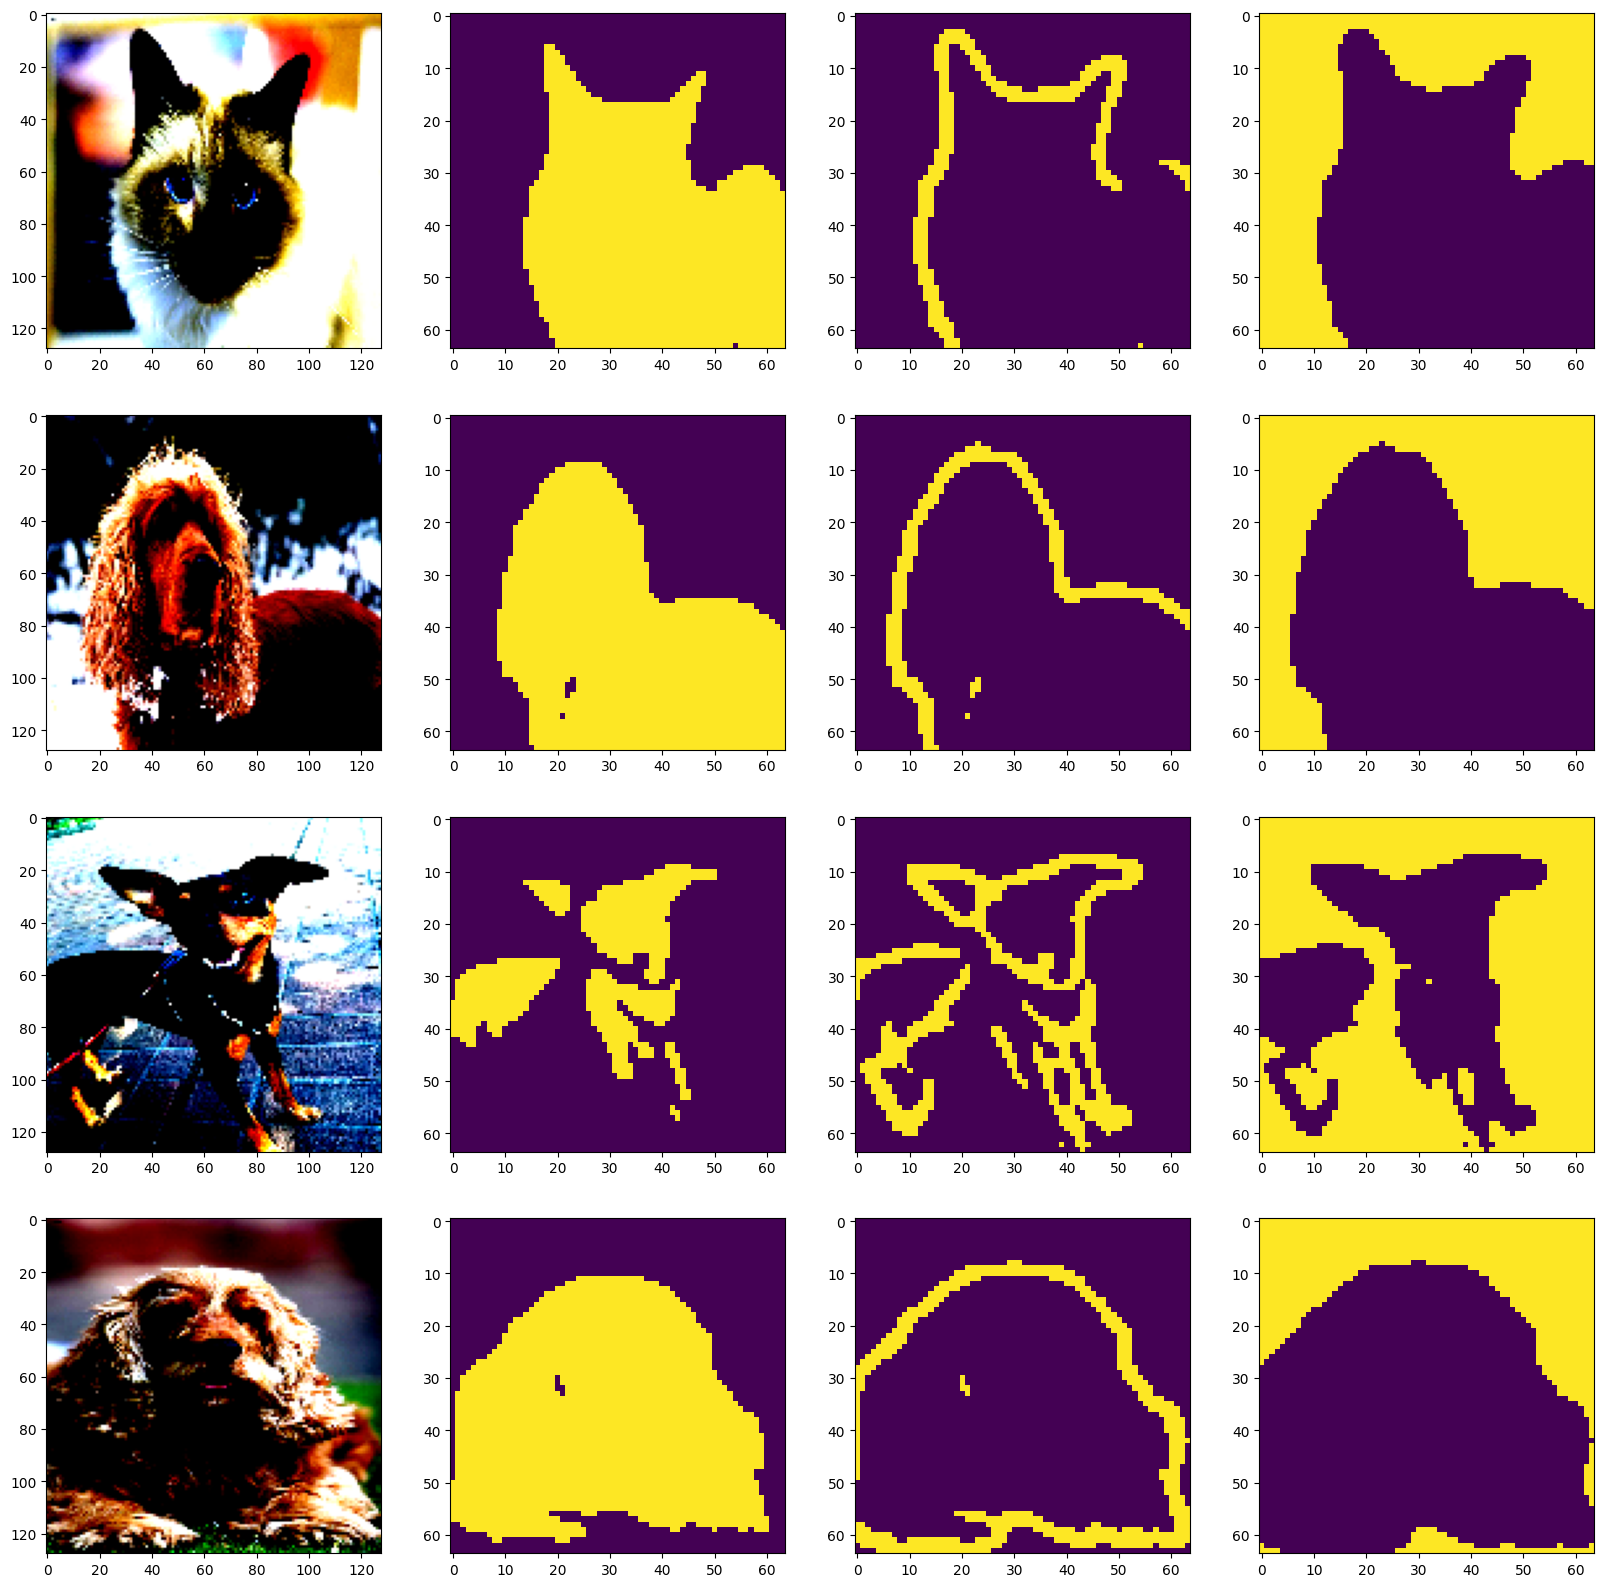

In [74]:
samples = next(iter(TEST_LOADER))
images, _ = samples

images = images[:4]
logits = model(images.to(DEVICE))
prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)


visualize_data(images.cpu(), prediction.cpu())

# Experiments and ablations (2p)

## No BiFPN (1p)
Disable BiFPN and train the model. Compare the performance with the previous one. 
That is, make BiFPN an identity on features.   
Do it without redefining the class `Net`.

In [75]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x, skip_down=False):
        return x
    
# I used bifpn3 with skip down to aggregate features from the backbone before segmentation head
# So I left it here, as removing it would mean that model only uses feature with highest resolution
model, optimizer = create_model_and_optimizer()
model.bifpn1 = Identity()
model.bifpn2 = Identity()

train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 loss: 0.6797173023223877

test eval:
IOU PET: 0.8026661792798759
IOU BG: 0.8907939261173426
IOU OUT: 0.45275629113665294
ACC PET: 0.9410105279239915
ACC BG: 0.939975009688437
ACC OUT: 0.9204833518584764

train eval:
IOU PET: 0.8115545326189857
IOU BG: 0.8953712559797835
IOU OUT: 0.4307192272892542
ACC PET: 0.9439685987389606
ACC BG: 0.9416296917459239
ACC OUT: 0.9196179597274117

Epoch 1 loss: 0.6640974879264832

test eval:
IOU PET: 0.8107266154380194
IOU BG: 0.8924959072737467
IOU OUT: 0.4688246361775808
ACC PET: 0.9445706292373603
ACC BG: 0.9411212529171777
ACC OUT: 0.9219605723204551

train eval:
IOU PET: 0.8251222712438422
IOU BG: 0.9034567109268711
IOU OUT: 0.46066077603790717
ACC PET: 0.9499168064283288
ACC BG: 0.9465882674507473
ACC OUT: 0.9235798711362092

Epoch 2 loss: 0.6405985951423645

test eval:
IOU PET: 0.8011762335435472
IOU BG: 0.8973058380193234
IOU OUT: 0.4445362841090485
ACC PET: 0.9388680924638866
ACC BG: 0.94445

In [76]:
# Version with bifpn3 as identity
model, optimizer = create_model_and_optimizer()
model.bifpn1 = Identity()
model.bifpn2 = Identity()
model.bifpn3 = Identity()

train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 loss: 0.8582898378372192

test eval:
IOU PET: 0.25793282937830253
IOU BG: 0.5928075171922769
IOU OUT: 0.119926912800494
ACC PET: 0.7076758371448283
ACC BG: 0.6634190440600299
ACC OUT: 0.8732709201034001

train eval:
IOU PET: 0.24909161711287006
IOU BG: 0.5962874229751467
IOU OUT: 0.11475688079428957
ACC PET: 0.7041459456734035
ACC BG: 0.6620040230129076
ACC OUT: 0.8795510333517323

Epoch 1 loss: 0.8667287230491638

test eval:
IOU PET: 0.22394294981105936
IOU BG: 0.5917745973940511
IOU OUT: 0.12143119417408371
ACC PET: 0.7121210064476016
ACC BG: 0.6517547915176138
ACC OUT: 0.8727935516532094

train eval:
IOU PET: 0.21804332052765796
IOU BG: 0.5961990404182005
IOU OUT: 0.11956449779847399
ACC PET: 0.7098115340523098
ACC BG: 0.6525748211404552
ACC OUT: 0.8791093245796535

Epoch 2 loss: 0.8654057383537292

test eval:
IOU PET: 0.2725259885928351
IOU BG: 0.5870336098749008
IOU OUT: 0.11654199482586433
ACC PET: 0.7090469239745162
ACC BG: 0

## Train Set Augmentations (1p)

To quickly see how data augmentation can help in learning we will restrict ourselves to first 20 images of `TRAIN_DATASET`.

In [77]:
images, masks = [], []
it = iter(TRAIN_DATASET)
for i in range(20):
    img, mask = next(it)
    images.append(img)
    masks.append(mask)

stacked_images = torch.stack(images).repeat((200, 1, 1, 1))
stacked_masks = torch.stack(masks).repeat((200, 1, 1))


SMALL_TRAIN_DATASET = torch.utils.data.TensorDataset(stacked_images, stacked_masks)

SMALL_TRAIN_LOADER = torch.utils.data.DataLoader(
    SMALL_TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

Complete the implementation of the augmentation function and train the model from scratch on the augmented dataset (use the `SMALL_TRAIN_LOADER` presented above). Write a short summary of the results. Augmentations are up to you, but they should result in performance improvement.

In [78]:

class HorizontalFlip(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.hflip(images)
        ground_truth = torchvision.transforms.functional.hflip(ground_truth)
        return images, ground_truth
    

class VerticalFlip(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.vflip(images)
        ground_truth = torchvision.transforms.functional.vflip(ground_truth)
        return images, ground_truth
    

class RandomRotation(torch.nn.Module):
    def __init__(self, degree=15):
        super().__init__()
        self.degree = degree

    def forward(self, images, ground_truth):
        angle = np.random.uniform(-self.degree, self.degree)
        images = torchvision.transforms.functional.rotate(images, angle)

        # After rotation, empty pixels are filled with 0, which is the pet class
        # We want empty pixels to be background, so we subtract 1 making pet class -1, background 0, outline 1
        # After rotation, we add 1 to make pet class 0, background 1, outline 2
        ground_truth = torchvision.transforms.Lambda(lambda x: x - 1)(ground_truth)
        ground_truth = torchvision.transforms.functional.rotate(ground_truth, angle)
        ground_truth = torchvision.transforms.Lambda(lambda x: x + 1)(ground_truth)
        
        return images, ground_truth
    

class RandomColorJitter(torch.nn.Module):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2):
        super().__init__()
        self.color_jitter = torchvision.transforms.ColorJitter(
            brightness, contrast, saturation, hue) 

    def forward(self, images, ground_truth):
        images = self.color_jitter(images)
        return images, ground_truth
    

class Grayscale(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.Grayscale(num_output_channels=3)(images)
        return images, ground_truth


class Invert(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.invert(images)
        return images, ground_truth
    

class Posterize(torch.nn.Module):
    def __init__(self, bits=6):
        super().__init__()
        self.bits = bits

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.convert_image_dtype(images, torch.uint8)
        images = torchvision.transforms.functional.posterize(images, self.bits)
        images = torchvision.transforms.functional.convert_image_dtype(images, torch.float32)
        return images, ground_truth
    

class Solarize(torch.nn.Module):
    def __init__(self, threshold=0.8):
        super().__init__()
        self.threshold = threshold

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.solarize(images, self.threshold)
        return images, ground_truth
    

class Equalize(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.convert_image_dtype(images, torch.uint8)
        images = torchvision.transforms.functional.equalize(images)
        images = torchvision.transforms.functional.convert_image_dtype(images, torch.float32)
        return images, ground_truth
    

class Autocontrast(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        images = torchvision.transforms.functional.autocontrast(images)
        return images, ground_truth
    


    

class RandomCrop(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, images, ground_truth):
        img_h = images.shape[-2]
        img_w = images.shape[-1]
        gt_h = ground_truth.shape[-2]
        gt_w = ground_truth.shape[-1]
        # resize ground truth to match image size
        ground_truth = torchvision.transforms.functional.resize(ground_truth, (img_h, img_w), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        params = torchvision.transforms.RandomCrop.get_params(images, (img_h*8//10, img_w*8//10))
        images = torchvision.transforms.functional.crop(images, *params)
        ground_truth = torchvision.transforms.functional.crop(ground_truth, *params)
        # resize ground truth back to original size
        ground_truth = torchvision.transforms.functional.resize(ground_truth, (gt_h, gt_w), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
        images = torchvision.transforms.functional.resize(images, (img_h, img_w))
        return images, ground_truth
        


def augment_data(images, ground_truth):
    """
    Args:
        images of shape (B, 3, H, W)
        ground_truth of shape (B, H', W')
    Returns augmented images and ground_truth.
    Augmentation is random.
    """

    batch_size = images.shape[0]
    assert len(images.shape) == 4 # (B, 3, H, W)
    assert len(ground_truth.shape) == 3 # (B, H', W')

    assert ground_truth.shape[0] == batch_size

    transformations = []

    transformations.append(HorizontalFlip())
    transformations.append(VerticalFlip())
    # transformations.append(RandomColorJitter())
    # transformations.append(Grayscale())
    transformations.append(Invert())
    # transformations.append(Posterize())
    # transformations.append(Solarize())
    # transformations.append(Equalize())
    # transformations.append(Autocontrast())
    # transformations.append(RandomCrop())

    # transformations.append(RandomRotation())

    num_of_transformations = np.random.randint(0, (len(transformations) + 1)//1)
    transformations_sample = np.random.choice(transformations, num_of_transformations, replace=False)

    aug_images, aug_gt = images, ground_truth
    for transformation in transformations_sample:
        aug_images, aug_gt = transformation(aug_images, aug_gt)
    
    assert aug_images.shape == images.shape
    assert ground_truth.shape == aug_gt.shape
    assert torch.logical_or(aug_gt == 0, torch.logical_or(aug_gt == 1, aug_gt == 2)).all()

    return aug_images, aug_gt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


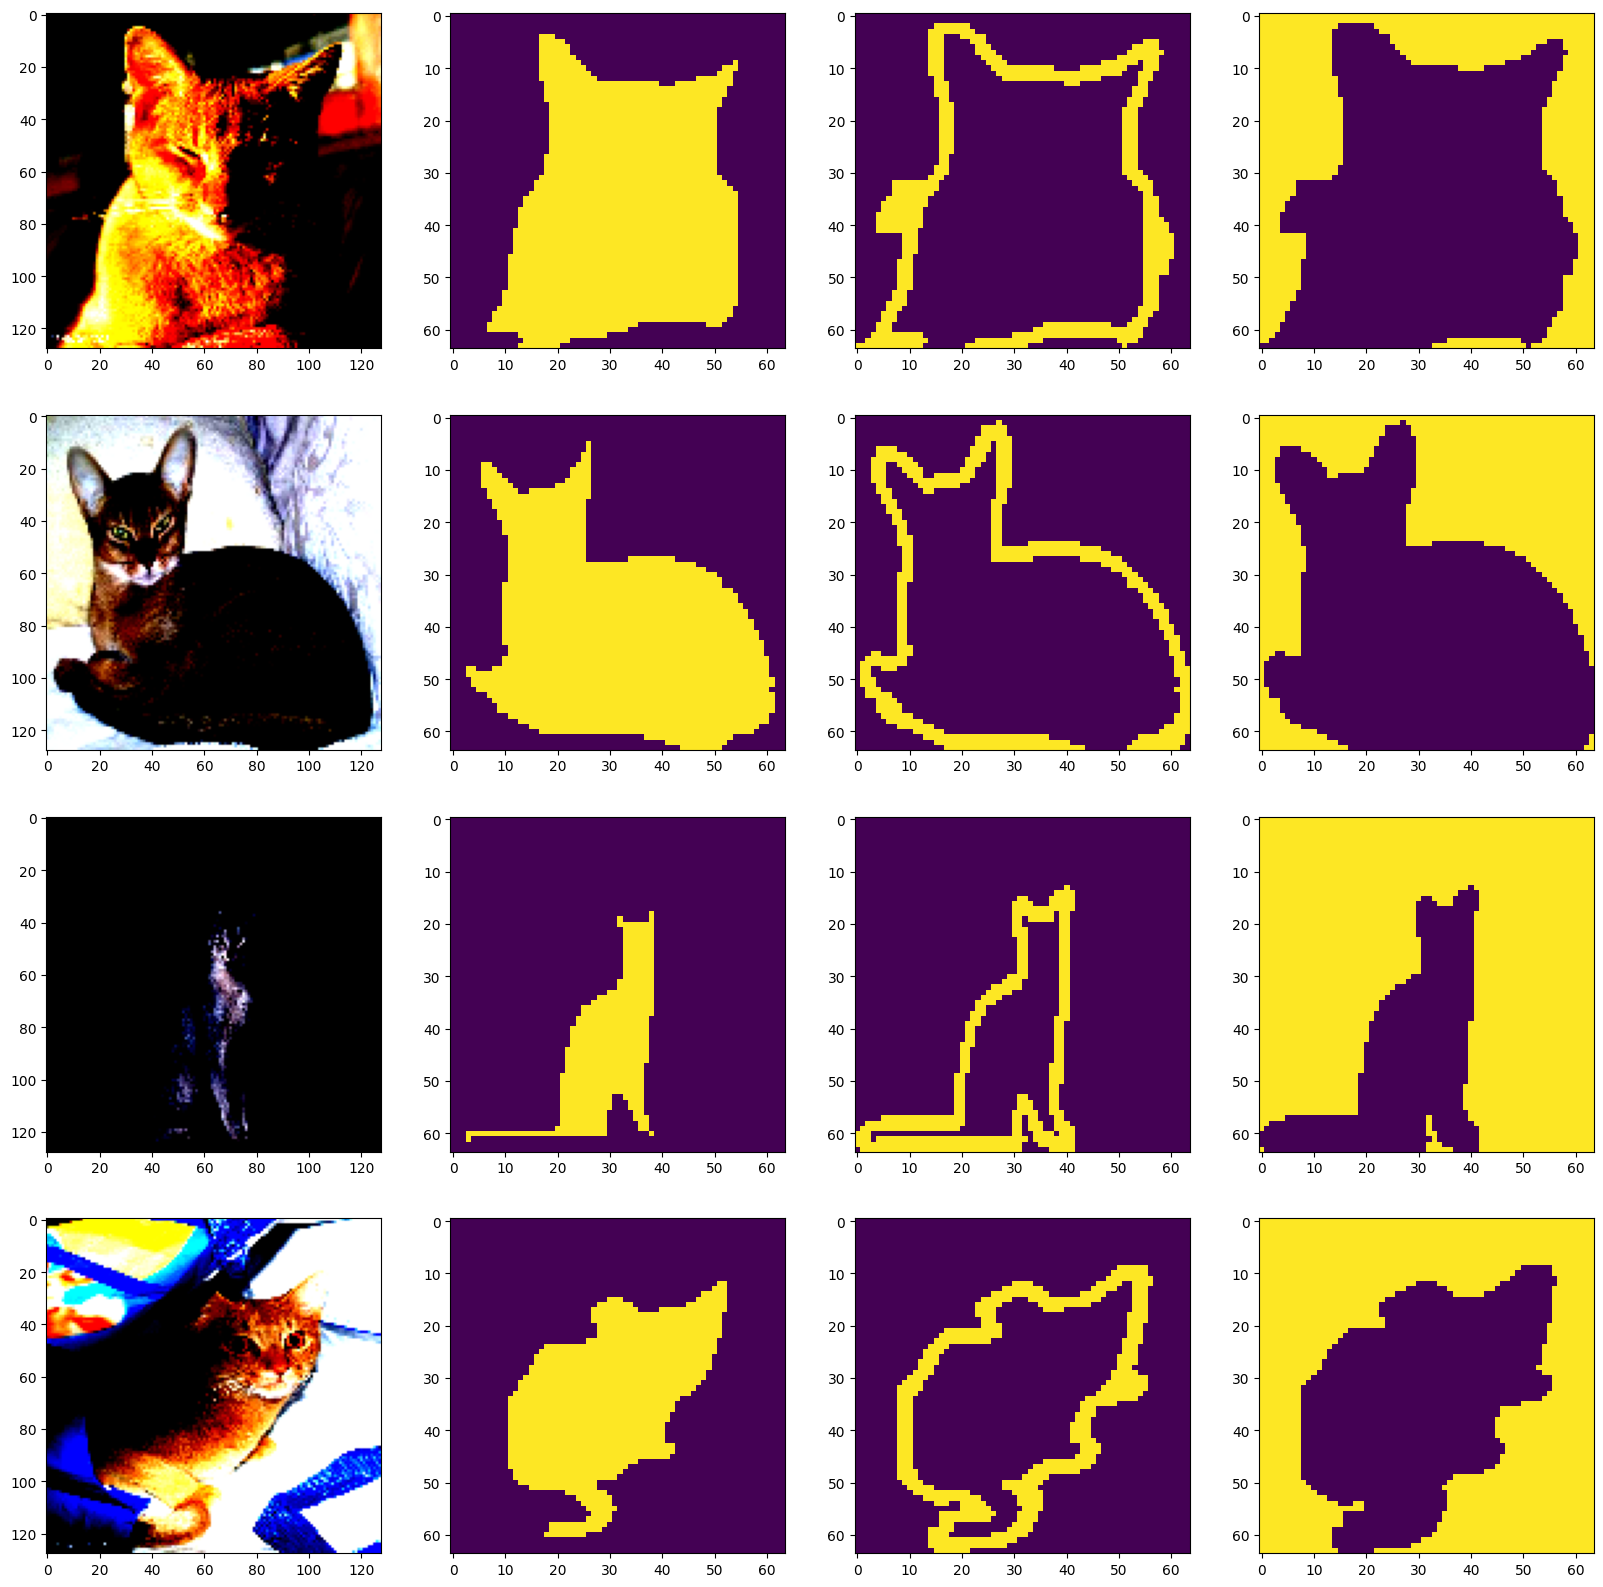

In [79]:
samples = next(iter(SMALL_TRAIN_LOADER))
images, masks = samples

images = images[:4]
masks = masks[:4]

visualize_data(images, masks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


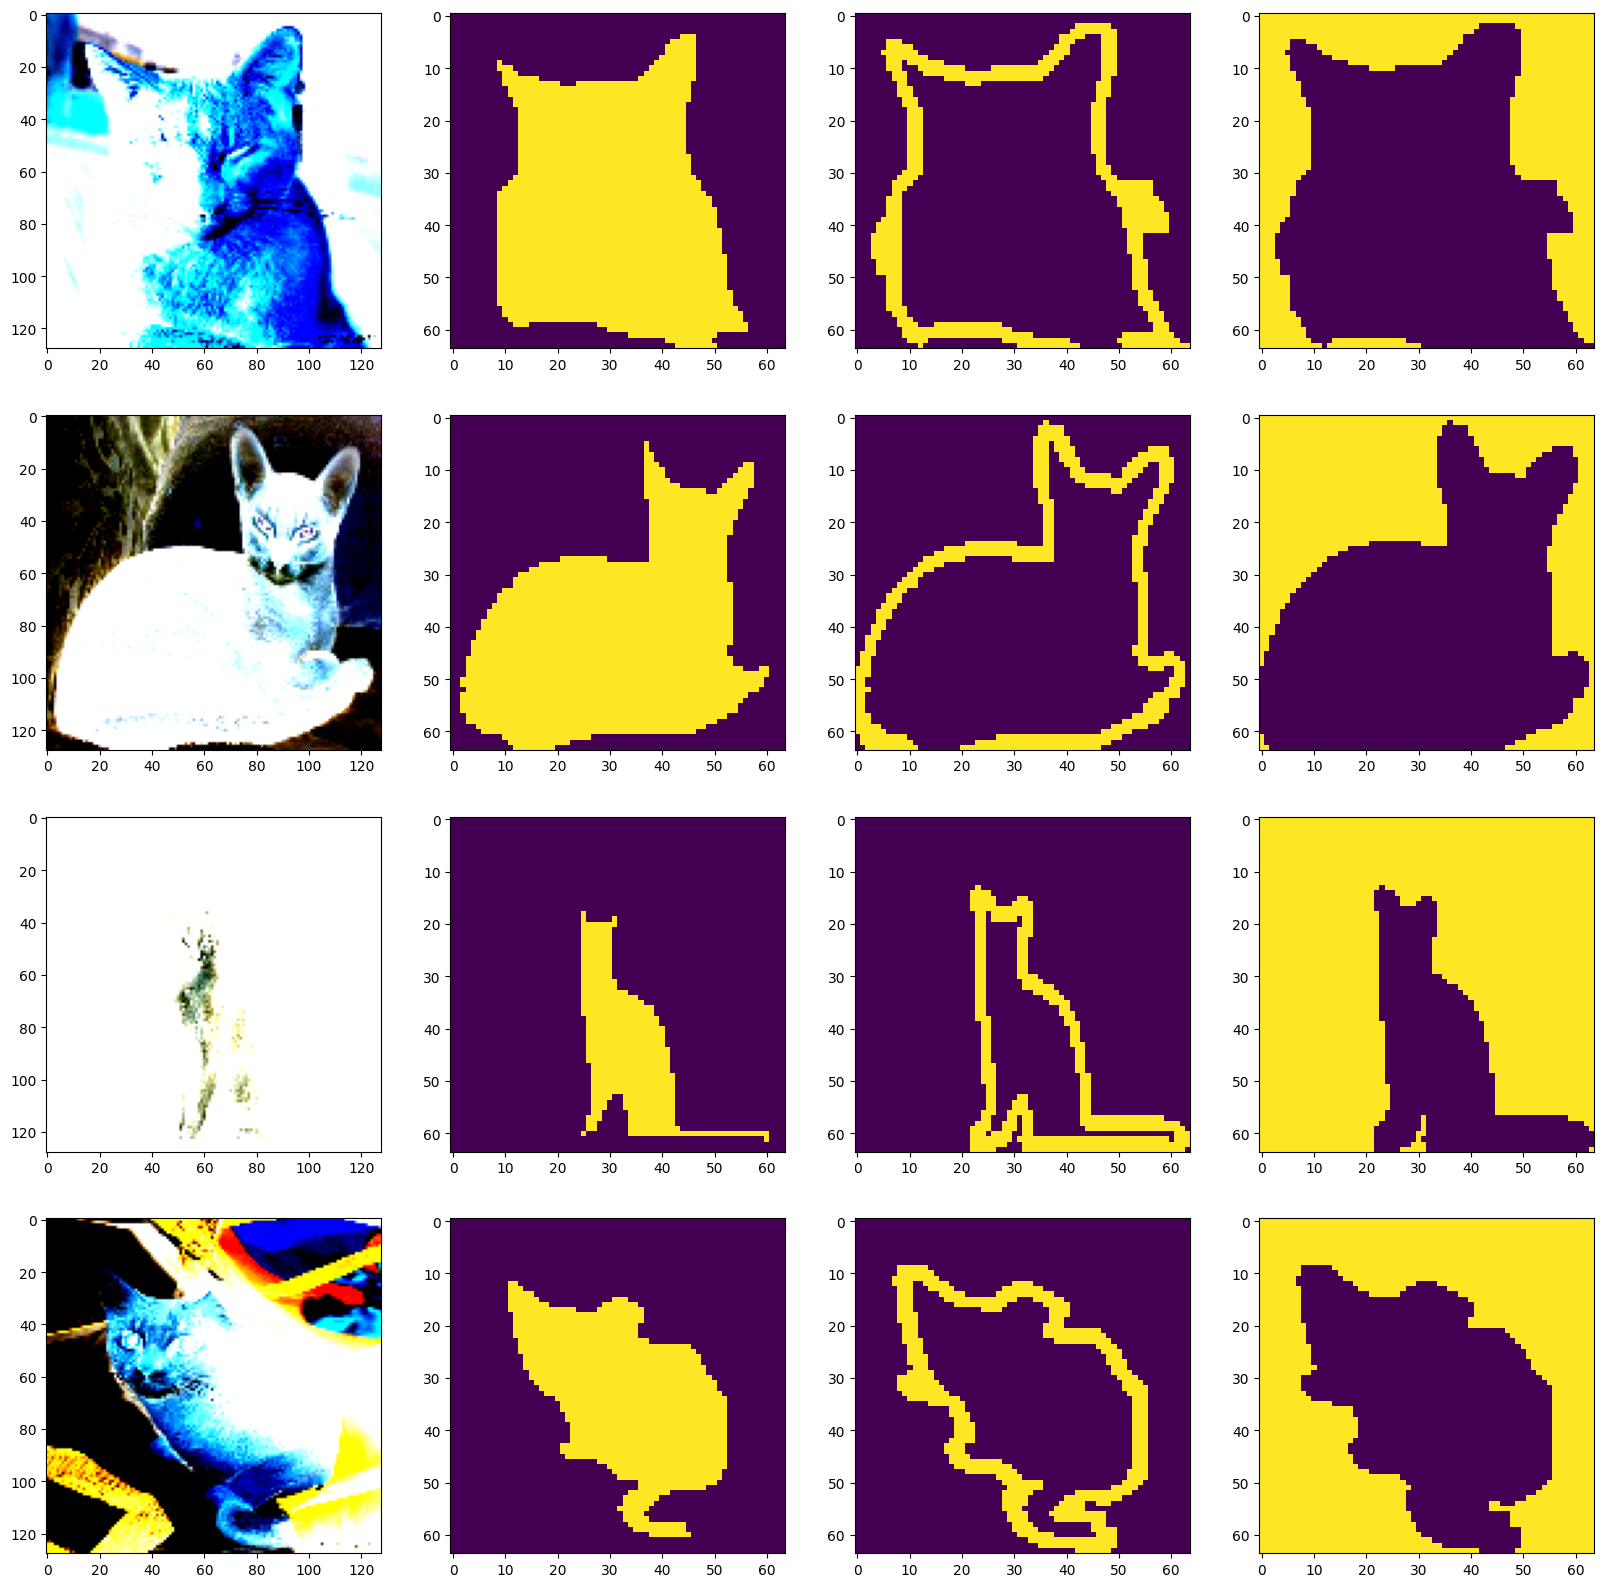

In [80]:
aug_imgs, aug_masks = augment_data(images, masks)

visualize_data(aug_imgs, aug_masks)

In [81]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Loaded pretrained weights for efficientnet-b0
Epoch 0 loss: 0.5620319247245789

test eval:
IOU PET: 0.5390559180765004
IOU BG: 0.7069752133845879
IOU OUT: 0.33451818361538993
ACC PET: 0.8201065541743322
ACC BG: 0.8072590613501636
ACC OUT: 0.8697390323700259

train eval:
IOU PET: 0.9715056097561919
IOU BG: 0.9911950212609701
IOU OUT: 0.9190013896718114
ACC PET: 0.9938232421875
ACC BG: 0.99525146484375
ACC OUT: 0.98907470703125

Epoch 1 loss: 0.5542530417442322

test eval:
IOU PET: 0.5169898206495274
IOU BG: 0.6971011965762541
IOU OUT: 0.3300721607501362
ACC PET: 0.8119453103706732
ACC BG: 0.7977241355997887
ACC OUT: 0.864705569999489

train eval:
IOU PET: 0.9948718224154316
IOU BG: 0.997076183905089
IOU OUT: 0.9823473671055677
ACC PET: 0.99888916015625
ACC BG: 0.9986083984375
ACC OUT: 0.99749755859375

Epoch 2 loss: 0.5528832674026489

test eval:
IOU PET: 0.5126364003019247
IOU BG: 0.7150055224416847
IOU OUT: 0.33434294147922133
ACC PET: 0.8174401046989984
ACC BG: 0.8079235443922049
ACC

In [82]:
model, optimizer = create_model_and_optimizer()
train(model, optimizer, SMALL_TRAIN_LOADER, TEST_LOADER, 3, eval_fn, augment_fn=augment_data)

Loaded pretrained weights for efficientnet-b0
Epoch 0 loss: 0.5962526798248291

test eval:
IOU PET: 0.6629220635853795
IOU BG: 0.7965001545820355
IOU OUT: 0.35318157526581817
ACC PET: 0.8883057638746934
ACC BG: 0.874881356572806
ACC OUT: 0.8846373996022417

train eval:
IOU PET: 0.9110366816124794
IOU BG: 0.9539021526528664
IOU OUT: 0.6982650447348487
ACC PET: 0.9789306640625
ACC BG: 0.97430419921875
ACC OUT: 0.95369873046875

Epoch 1 loss: 0.5756239891052246

test eval:
IOU PET: 0.6378411257014257
IOU BG: 0.7852162052828243
IOU OUT: 0.35766094189284064
ACC PET: 0.876296427309042
ACC BG: 0.8673044133491755
ACC OUT: 0.8725467493697193

train eval:
IOU PET: 0.9535041722432107
IOU BG: 0.9782880202831915
IOU OUT: 0.8471483509390441
ACC PET: 0.9893310546875
ACC BG: 0.988330078125
ACC OUT: 0.977685546875

Epoch 2 loss: 0.5747523307800293

test eval:
IOU PET: 0.6379997573146061
IOU BG: 0.786370979559749
IOU OUT: 0.35489937010641637
ACC PET: 0.8747911928914555
ACC BG: 0.8663664448972813
ACC OUT

YOUR REPORT HERE

# Optional
Below you are provided with code for testing you model on images from the web. It may not work in colab!

In [83]:
load_checkpoint(model, "pet_segmentator.model")

In [84]:
import io
import requests
from PIL import Image


def download_image(url):
    req = requests.get(url, timeout=4.0)
    if req.status_code != requests.codes.ok:
        print(req.status_code)
        raise ConnectionError("Could not request image")

    return Image.open(io.BytesIO(req.content))


img_list = [
    download_image(
        "https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Young_tabby_cat_keeping_watch.jpg/1920px-Young_tabby_cat_keeping_watch.jpg?20190125193716"  #By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=76097663
    ),
    download_image( 
        "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Cat_blooper.jpg/1920px-Cat_blooper.jpg?20190116232839" # By W.carter - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=75900016
    ),
]
img = []
for i in img_list:
    img.append(input_transforms(i))


img = torch.stack(img, dim=0)
logits = model(img.to(DEVICE))

prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)

masks = prediction.detach().cpu()



visualize_data(img, masks)

403


ConnectionError: Could not request image